<p style="font-size:36px;text-align:center"> <b>IMDB review classifier</b> </p>

<h1>2. Exploratory Data Analysis</h1>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split

import re
from tqdm import tqdm
import os

from random import randint
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy.sparse import hstack
from prettytable import PrettyTable

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [2]:
# unpacking the data from txt file to list
reviews = []
rating = []
f = open("imdb_labelled.txt", "r")
all_data = f.read().split("\n")
for data in tqdm(all_data):
    row = data.split("\t")
    reviews.append(row[0].strip())
    rating.append(int(row[1]))

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 499381.35it/s]


In [3]:
# Creating a dataframe containg reviews and rating
all_train = pd.DataFrame(list(zip(reviews, rating)), columns =['Reviews', 'Rating'])
print("Train data set size is: ", all_train.shape[0])
print(100*'-')
all_train.head()

Train data set size is:  1000
----------------------------------------------------------------------------------------------------


,Reviews,Rating
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [4]:
#checking duplicate rows
#train[train.duplicated(keep = False)] 

In [5]:
train=all_train.drop_duplicates(subset={"Reviews"}, keep='first', inplace=False) #dropping duplicate data points
#Checking to see how much % of data still remains
print("Data remaining after removing dulicate rows: ",(train['Rating'].size)/(all_train['Rating'].size)*100,"%")

Data remaining after removing dulicate rows:  99.7 %


Text(0.5, 1.0, 'Distribution of data points')

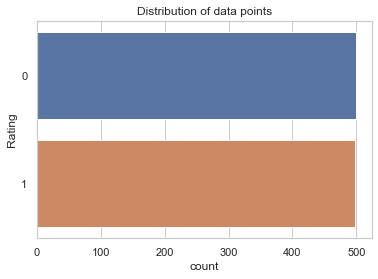

In [6]:
sns.set_theme(style="whitegrid")
sns.countplot(y = train.Rating)
plt.title('Distribution of data points')

<h1>3. Pre-Processing data</h1>

In [7]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [8]:
# fucntion dealing with punctuations
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
# Combining above 
preprocessed_reviews = []
for sentance in tqdm(train['Reviews'].values):
    sentance = decontracted(sentance)        #puncuation
    sentance = re.sub('[^A-Za-z1-10]+', ' ', sentance) #special characteristics
    sentance = ' '.join(w.lower() for w in sentance.split() if w.lower() not in stopwords)  #stop words and lower case
    preprocessed_reviews.append(sentance.strip())

100%|█████████████████████████████████████████████████████████████████████████████| 997/997 [00:00<00:00, 31132.53it/s]


In [10]:
preprocessed_train = pd.DataFrame(list(zip(preprocessed_reviews, rating)), columns =['Preprocessed_Reviews', 'Rating'])
print("Train data set size is: ", preprocessed_train.shape[0])

Train data set size is:  997


In [11]:
y = preprocessed_train['Rating'].values
X = preprocessed_train.drop(['Rating'], axis=1)
X.head(5)

,Preprocessed_Reviews
0,slow moving aimless movie distressed drifting ...
1,not sure lost flat characters audience nearly ...
2,attempting artiness black white clever camera ...
3,little music anything speak
4,best scene movie gerardo trying find song keep...


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

<h2>3.1. Feature enginering</h2>

In [13]:
sentiScoresTrainList=[]
sentiScoresTestList=[]
sid = SentimentIntensityAnalyzer()
for sentence in X_train['Preprocessed_Reviews'].values:
    sentiScores = sid.polarity_scores(sentence)
    sentiScoresTrainList.append(list(sentiScores.values()))

for sentence in X_test['Preprocessed_Reviews'].values:
    sentiScores = sid.polarity_scores(sentence)
    sentiScoresTestList.append(list(sentiScores.values()))
    
X_train_sentiscores = np.array(sentiScoresTrainList)
X_test_sentiscores = np.array(sentiScoresTestList)

print("After vectorizations")
print(X_train_sentiscores.shape, y_train.shape)
print(X_test_sentiscores.shape, y_test.shape)
print("="*100)

After vectorizations
(847, 4) (847,)
(150, 4) (150,)


In [14]:
# Apply TF-IDF vectorization on 'Preprocessed_Essay' 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer_tfidf = TfidfVectorizer(min_df=3,ngram_range=(1,3))
vectorizer_tfidf.fit(X_train['Preprocessed_Reviews'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer_tfidf.transform(X_train['Preprocessed_Reviews'].values)
X_test_tfidf = vectorizer_tfidf.transform(X_test['Preprocessed_Reviews'].values)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)

print("NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME")

(847, 1) (847,)
(150, 1) (150,)
After vectorizations
(847, 576) (847,)
(150, 576) (150,)
NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME


In [15]:
#Joining all the features
X_tr_tfidf=hstack((X_train_sentiscores, X_train_tfidf)).tocsr()
X_te_tfidf = hstack((X_test_sentiscores, X_test_tfidf)).tocsr()


print("Final Data matrix")
print(X_tr_tfidf.shape, y_train.shape)
print(X_te_tfidf.shape, y_test.shape)
print("="*100)

Final Data matrix
(847, 580) (847,)
(150, 580) (150,)


<h1>4. Machine Learning Models</h1>

<h2>4.1. Random model</h2>

In [16]:
y_test_rand=[]
for i in tqdm(range(0,150)):
    y_test_rand.append(randint(0, 1))
    
y_train_rand=[]
for i in tqdm(range(0,847)):
    y_train_rand.append(randint(0, 1))

100%|████████████████████████████████████████████████████████████████████████████| 847/847 [00:00<00:00, 424137.47it/s]


In [17]:
print("Train accuracy for a random model is: ",accuracy_score(y_train, y_train_rand))
print("Test accuracy for a random model is: ",accuracy_score(y_test, y_test_rand))
print("Train f1 score for a random model is: ",f1_score(y_train, y_train_rand))
print("Test f1 score for a random model is: ",f1_score(y_test, y_test_rand))

Train accuracy for a random model is:  0.4722550177095632
Test accuracy for a random model is:  0.5
Train f1 score for a random model is:  0.4697508896797153
Test f1 score for a random model is:  0.5161290322580646


<h2>4.2. Logistic regression</h2>

In [18]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot
probs = LogisticRegression(random_state=42)

parameters = {'C': [ 0.001, 0.05, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100,500,1000]}
clf = RandomizedSearchCV(probs, parameters, cv=3, scoring='accuracy',return_train_score=True,random_state=42)
clf.fit(X_tr_tfidf, y_train)
results = pd.DataFrame.from_dict(clf.cv_results_)
print(clf.best_params_)

{'C': 1}


In [19]:
logi = LogisticRegression(C=1, random_state=42)
logi.fit(X_tr_tfidf, y_train)
y_pred_train = logi.predict(X_tr_tfidf)
y_pred_test = logi.predict(X_te_tfidf)

In [20]:
print("Train accuracy for a Logistic regression is: ",accuracy_score(y_train, y_pred_train))
print("Test accuracy for a Logistic regression is: ",accuracy_score(y_test, y_pred_test))
print("Train f1 score for a Logistic regression is: ",f1_score(y_train, y_pred_train))
print("Test f1 score for a Logistic regression is: ",f1_score(y_test, y_pred_test))

Train accuracy for a Logistic regression is:  0.8134592680047226
Test accuracy for a Logistic regression is:  0.6866666666666666
Train f1 score for a Logistic regression is:  0.8204545454545453
Test f1 score for a Logistic regression is:  0.6887417218543047


<h2>4.3. SVM</h2>

In [21]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot

probs = svm.SVC(random_state=42)

parameters = {'C': [ 0.001, 0.05, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100,500,1000]}
clf = RandomizedSearchCV(probs, parameters, cv=3, scoring='accuracy',return_train_score=True,random_state=42)
clf.fit(X_tr_tfidf, y_train)
results = pd.DataFrame.from_dict(clf.cv_results_)

print(clf.best_params_)

{'C': 0.5}


In [22]:
sv = svm.SVC(C=0.4,random_state=42)
sv.fit(X_tr_tfidf, y_train)
y_pred_train = sv.predict(X_tr_tfidf)
y_pred_test = sv.predict(X_te_tfidf)

In [23]:
print("Train accuracy for a Logistic regression is: ",accuracy_score(y_train, y_pred_train))
print("Test accuracy for a Logistic regression is: ",accuracy_score(y_test, y_pred_test))
print("Train f1 score for a Logistic regression is: ",f1_score(y_train, y_pred_train))
print("Test f1 score for a Logistic regression is: ",f1_score(y_test, y_pred_test))

Train accuracy for a Logistic regression is:  0.7804014167650531
Test accuracy for a Logistic regression is:  0.7333333333333333
Train f1 score for a Logistic regression is:  0.7937915742793793
Test f1 score for a Logistic regression is:  0.7435897435897435


<h2>4.4. Random Forrest</h2>

In [24]:
probs = RandomForestClassifier(random_state=42)

parameters = {'n_estimators': [ 1, 5, 10, 50, 100], 'max_depth':[1,3,5,7,10]}
clf = RandomizedSearchCV(probs, parameters, cv=3, scoring='accuracy',return_train_score=True,random_state=42)
clf.fit(X_tr_tfidf, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)

print(clf.best_params_)

{'n_estimators': 50, 'max_depth': 10}


In [25]:
rdf = RandomForestClassifier(n_estimators = 50, max_depth= 10, random_state=42)
rdf.fit(X_tr_tfidf, y_train)
y_pred_train = rdf.predict(X_tr_tfidf)
y_pred_test = rdf.predict(X_te_tfidf)

In [30]:
print("Train accuracy for random forrest is: ",accuracy_score(y_train, y_pred_train))
print("Test accuracy for a random forrest is: ",accuracy_score(y_test, y_pred_test))
print("Train f1 score for a random forrest is: ",f1_score(y_train, y_pred_train))
print("Test f1 score for a random forrest is: ",f1_score(y_test, y_pred_test))

Train accuracy for random forrest is:  0.781582054309327
Test accuracy for a random forrest is:  0.72
Train f1 score for a random forrest is:  0.7960308710033076
Test f1 score for a random forrest is:  0.7236842105263158


In [29]:
# Specifying the Column Names while initializing the Table
myTable = PrettyTable(["Model", "Train Accuracy", "Test Accuracy", "Train F1", "Test F1"])
  
# Adding rows
myTable.add_row(["Worst/Random", "0.47", "0.50", "0.47" , "0.52"])
myTable.add_row(["Logistic regression", "0.81", "0.68", "0.82", "0.69"])
myTable.add_row(["SVM", "0.78", "0.73", "0.79", "0.74"])
myTable.add_row(["Random forrest", "0.78", "0.72", "0.80", "0.72"])
  
print(myTable)

+---------------------+----------------+---------------+----------+---------+
|        Model        | Train Accuracy | Test Accuracy | Train F1 | Test F1 |
+---------------------+----------------+---------------+----------+---------+
|     Worst/Random    |      0.47      |      0.50     |   0.47   |   0.52  |
| Logistic regression |      0.81      |      0.68     |   0.82   |   0.69  |
|         SVM         |      0.78      |      0.73     |   0.79   |   0.74  |
|    Random forrest   |      0.78      |      0.72     |   0.80   |   0.72  |
+---------------------+----------------+---------------+----------+---------+


#### Summary Points
<ol>
    <li>From the above table, it can be seen that Best test score and accuracy is from SVM</li>
    <li>Train and test accuracy of our best model(SVM) are close indicating model is not overfit</li>
    <li>Adding sentiment scores improved performance metrics</li>
    <li>Model can be improved with much larger data points</li>
</ol>    